Random Forest Training Accuracy: 99.49%
Random Forest Test Accuracy: 80.81%
Confusion Matrix:
[[53  6]
 [13 27]]
True Positives: 27
False Positives: 6
True Negatives: 53
False Negatives: 13

Evaluation Metrics:
      Metric     Score
0   Accuracy  0.808081
1  Precision  0.818182
2     Recall  0.675000
3   F1 Score  0.739726


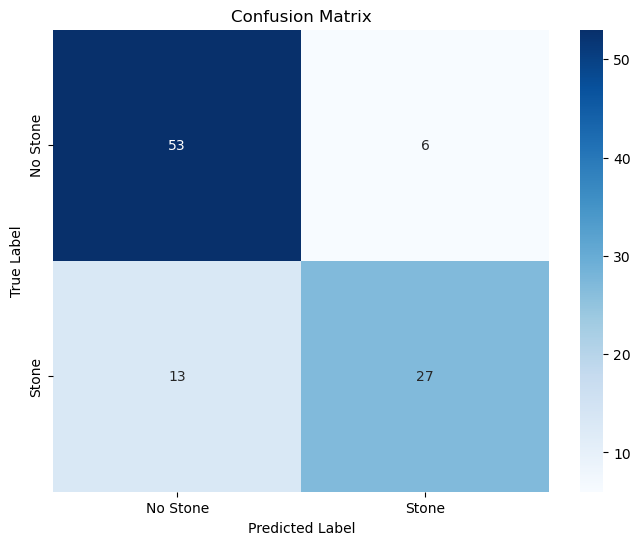


Feature Importances:
              Input Name  Importance
0  Calcium Concentration    0.308987
1                     ph    0.151118
2           Conductivity    0.143545
3     Urea Concentration    0.139098
4                gravity    0.133066
5             Osmolarity    0.124187


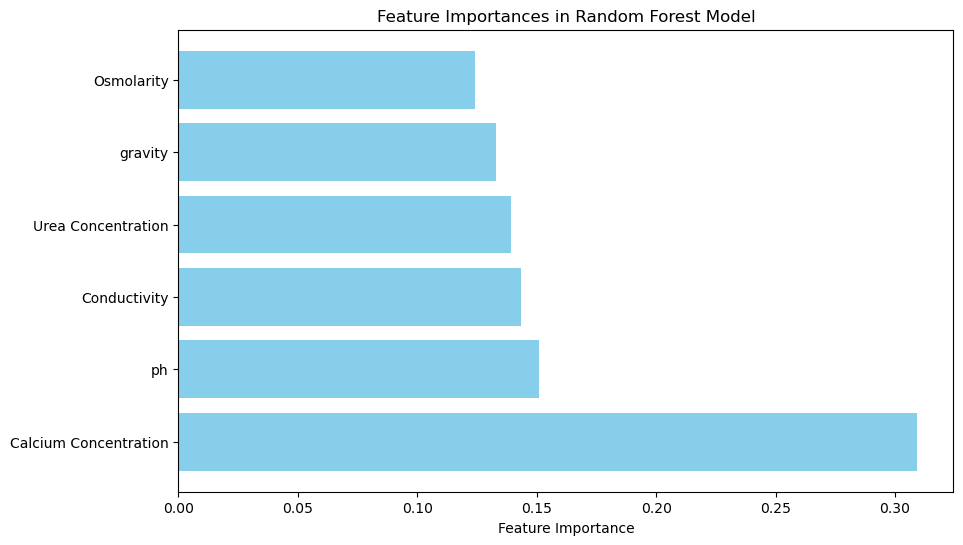

In [1]:
import os
import random
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.ensemble import RandomForestClassifier
import joblib  # For saving the model and scaler
import matplotlib.pyplot as plt
import seaborn as sns

# Set random seeds for reproducibility
def set_random_seed(seed_value=42):
    os.environ['PYTHONHASHSEED'] = str(seed_value)
    random.seed(seed_value)
    np.random.seed(seed_value)
    tf.random.set_seed(seed_value)

set_random_seed(42)

# Load dataset
data = pd.read_csv('urine.csv')

# Feature and target extraction
X = data[['gravity', 'ph', 'Osmolarity', 'Conductivity', 'Urea Concentration', 'Calcium Concentration']]
y = data['KidneyStone']  # Binary classification: 1 (stone present) or 0 (no stone)

# Normalize the feature data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data into training and testing sets (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=50)

# Instantiate and train the Random Forest model
random_forest = RandomForestClassifier(random_state=42)
random_forest.fit(X_train, y_train)

# Save the trained Random Forest model and scaler
joblib.dump(random_forest, 'random_forest_model.pkl')  # Save the trained Random Forest model
joblib.dump(scaler, 'scaler.pkl')  # Save the scaler used for data normalization

# Make predictions on training and test data
y_train_pred = random_forest.predict(X_train)
y_test_pred = random_forest.predict(X_test)

# Calculate accuracy, precision, recall, and F1 score for test data
test_accuracy = accuracy_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred)
test_recall = recall_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred)

# Calculate accuracy for training data
train_accuracy = accuracy_score(y_train, y_train_pred)

# Print training and testing accuracies
print(f"Random Forest Training Accuracy: {train_accuracy * 100:.2f}%")
print(f"Random Forest Test Accuracy: {test_accuracy * 100:.2f}%")

# Confusion matrix for test data
cm = confusion_matrix(y_test, y_test_pred)

# Extract True Positives, False Positives, True Negatives, and False Negatives
TN, FP, FN, TP = cm.ravel()

# Print confusion matrix and TP, FP, TN, FN values
print("Confusion Matrix:")
print(cm)
print(f"True Positives: {TP}")
print(f"False Positives: {FP}")
print(f"True Negatives: {TN}")
print(f"False Negatives: {FN}")

# Create a DataFrame for metrics
metrics_df = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1 Score'],
    'Score': [test_accuracy, test_precision, test_recall, test_f1]
})

# Print the DataFrame
print("\nEvaluation Metrics:")
print(metrics_df)

# Plot the confusion matrix using Seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True,
            xticklabels=['No Stone', 'Stone'], yticklabels=['No Stone', 'Stone'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Feature importances
importances = random_forest.feature_importances_
features = X.columns

# Create DataFrame for feature importances
importance_df = pd.DataFrame({
    'Input Name': features,
    'Importance': importances
})

# Sort the DataFrame by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False).reset_index(drop=True)

# Print the DataFrame
print("\nFeature Importances:")
print(importance_df)

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Input Name'], importance_df['Importance'], color='skyblue')
plt.xlabel('Feature Importance')
plt.title('Feature Importances in Random Forest Model')
plt.show()


In [6]:
# Calculate max and min values before normalization
max_values_raw = data[X.columns].max()
min_values_raw = data[X.columns].min()

# Create a DataFrame for the results
raw_stats = pd.DataFrame({
    'Attribute': X.columns,
    'Max Value': max_values_raw,
    'Min Value': min_values_raw
})

# Print the DataFrame
print("\nMax and Min Values Before Normalization:")
print(raw_stats)



Max and Min Values Before Normalization:
                                   Attribute  Max Value  Min Value
gravity                              gravity       1.04      1.005
ph                                        ph       7.94      4.760
Osmolarity                        Osmolarity    1236.00    187.000
Conductivity                    Conductivity      38.00      5.100
Urea Concentration        Urea Concentration     620.00     10.000
Calcium Concentration  Calcium Concentration      14.34      0.170


In [7]:
# Find the indices where the actual target is 1 (stone present) but the model predicts 0 (no stone)
misclassified_indices = (y_test == 1) & (y_test_pred == 0)

# Extract the corresponding input values from X_test, along with predicted and actual values
misclassified_data = pd.DataFrame(X_test[misclassified_indices], columns=X.columns)
misclassified_data['Actual'] = y_test[misclassified_indices].values
misclassified_data['Predicted'] = y_test_pred[misclassified_indices]

# Reverse the scaling to get the original feature values
original_values = scaler.inverse_transform(misclassified_data[X.columns])
misclassified_data[X.columns] = original_values

# Add a column to indicate the kidney stone presence (Actual: 1 means stone is present, Predicted: 0 means model predicted no stone)
misclassified_data['Stone Present'] = misclassified_data['Actual']
misclassified_data['Model Prediction (No Stone = 0, Stone = 1)'] = misclassified_data['Predicted']

# Display the misclassified data in tabular form directly in the console
print("\nMisclassified Samples (Actual: Stone Present, Predicted: No Stone):")
display(misclassified_data)  # This will display it in a table format directly in Jupyter Notebook


Misclassified Samples (Actual: Stone Present, Predicted: No Stone):


,gravity,ph,Osmolarity,Conductivity,Urea Concentration,Calcium Concentration,Actual,Predicted,Stone Present,"Model Prediction (No Stone = 0, Stone = 1)"
0,1.023,5.64,876.0,35.8,308.0,4.49,1,0,1,0
1,1.026,6.19,577.0,17.9,164.0,1.16,1,0,1,0
2,1.012,6.81,461.0,17.4,195.0,1.40,1,0,1,0
3,1.017,6.76,567.0,21.4,301.0,3.46,1,0,1,0
4,1.013,5.41,456.0,17.8,164.0,3.30,1,0,1,0
5,1.012,6.75,251.0,5.1,141.0,0.65,1,0,1,0
6,1.028,6.76,631.0,11.2,422.0,2.15,1,0,1,0
7,1.008,7.12,325.0,12.6,75.0,1.03,1,0,1,0
8,1.020,5.86,703.0,21.4,272.0,6.63,1,0,1,0
9,1.017,5.87,410.0,23.6,252.0,2.46,1,0,1,0


Random Forest Training Accuracy: 99.49%
Random Forest Test Accuracy: 84.85%
Confusion Matrix:
[[51  8]
 [ 7 33]]
True Positives: 33
False Positives: 8
True Negatives: 51
False Negatives: 7

Evaluation Metrics:
      Metric     Score
0   Accuracy  0.848485
1  Precision  0.804878
2     Recall  0.825000
3   F1 Score  0.814815


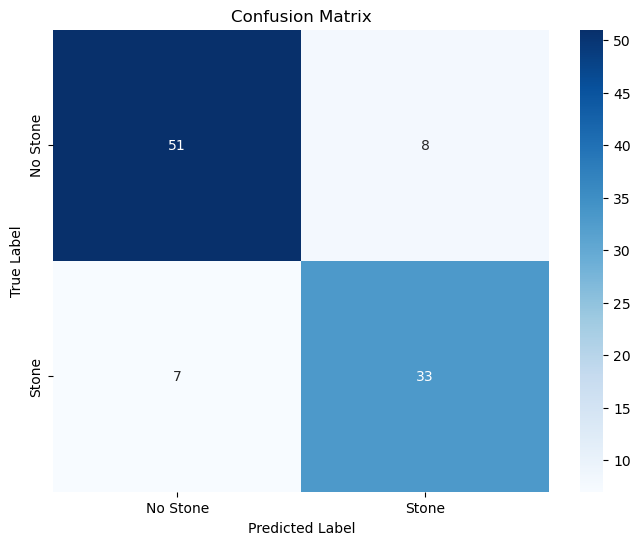


Feature Importances:
              Input Name  Importance
0  Calcium Concentration    0.295628
1                     ph    0.151911
2     Urea Concentration    0.142979
3           Conductivity    0.142738
4             Osmolarity    0.135157
5                gravity    0.131587


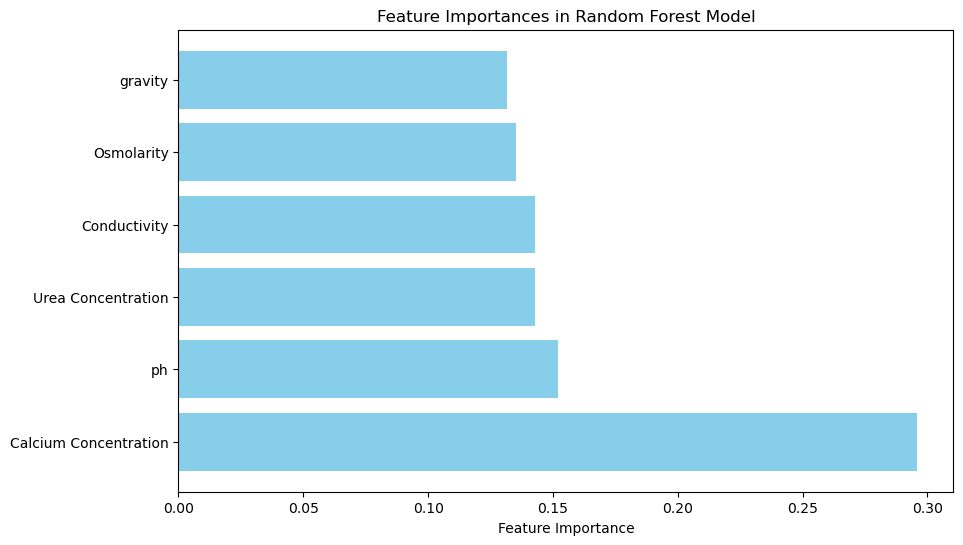

In [1]:
import os
import random
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.ensemble import RandomForestClassifier
import joblib  # For saving the model and scaler
import matplotlib.pyplot as plt
import seaborn as sns

# Set random seeds for reproducibility
def set_random_seed(seed_value=42):
    os.environ['PYTHONHASHSEED'] = str(seed_value)
    random.seed(seed_value)
    np.random.seed(seed_value)
    tf.random.set_seed(seed_value)

set_random_seed(42)

# Load dataset
data = pd.read_csv('urine.csv')

# Feature and target extraction
X = data[['gravity', 'ph', 'Osmolarity', 'Conductivity', 'Urea Concentration', 'Calcium Concentration']]
y = data['KidneyStone']  # Binary classification: 1 (stone present) or 0 (no stone)

# Normalize the feature data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data into training and testing sets (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=50)

# Instantiate and train the Random Forest model with class weights to penalize false negatives
random_forest = RandomForestClassifier(random_state=42, class_weight={0: 1, 1: 2})  # Higher weight for positive class
random_forest.fit(X_train, y_train)

# Save the trained Random Forest model and scaler
joblib.dump(random_forest, 'random_forest_model.pkl')  # Save the trained Random Forest model
joblib.dump(scaler, 'scaler.pkl')  # Save the scaler used for data normalization

# Make predictions on test data
y_train_pred = random_forest.predict(X_train)
y_test_proba = random_forest.predict_proba(X_test)[:, 1]  # Predicted probabilities for the positive class

# Adjust threshold to increase recall
threshold = 0.4  # Lowering threshold to classify more cases as positive (increase recall)
y_test_pred = (y_test_proba >= threshold).astype(int)

# Calculate accuracy, precision, recall, and F1 score for test data
test_accuracy = accuracy_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred)
test_recall = recall_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred)

# Calculate accuracy for training data
train_accuracy = accuracy_score(y_train, y_train_pred)

# Print training and testing accuracies
print(f"Random Forest Training Accuracy: {train_accuracy * 100:.2f}%")
print(f"Random Forest Test Accuracy: {test_accuracy * 100:.2f}%")

# Confusion matrix for test data
cm = confusion_matrix(y_test, y_test_pred)

# Extract True Positives, False Positives, True Negatives, and False Negatives
TN, FP, FN, TP = cm.ravel()

# Print confusion matrix and TP, FP, TN, FN values
print("Confusion Matrix:")
print(cm)
print(f"True Positives: {TP}")
print(f"False Positives: {FP}")
print(f"True Negatives: {TN}")
print(f"False Negatives: {FN}")

# Create a DataFrame for metrics
metrics_df = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1 Score'],
    'Score': [test_accuracy, test_precision, test_recall, test_f1]
})

# Print the DataFrame
print("\nEvaluation Metrics:")
print(metrics_df)

# Plot the confusion matrix using Seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True,
            xticklabels=['No Stone', 'Stone'], yticklabels=['No Stone', 'Stone'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Feature importances
importances = random_forest.feature_importances_
features = X.columns

# Create DataFrame for feature importances
importance_df = pd.DataFrame({
    'Input Name': features,
    'Importance': importances
})

# Sort the DataFrame by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False).reset_index(drop=True)

# Print the DataFrame
print("\nFeature Importances:")
print(importance_df)

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Input Name'], importance_df['Importance'], color='skyblue')
plt.xlabel('Feature Importance')
plt.title('Feature Importances in Random Forest Model')
plt.show()


Random Forest Training Accuracy: 99.49%
Random Forest Validation Accuracy: 84.85%
Confusion Matrix:
[[51  8]
 [ 7 33]]
True Positives: 33
False Positives: 8
True Negatives: 51
False Negatives: 7

Evaluation Metrics:
      Metric     Score
0   Accuracy  0.848485
1  Precision  0.804878
2     Recall  0.825000
3   F1 Score  0.814815


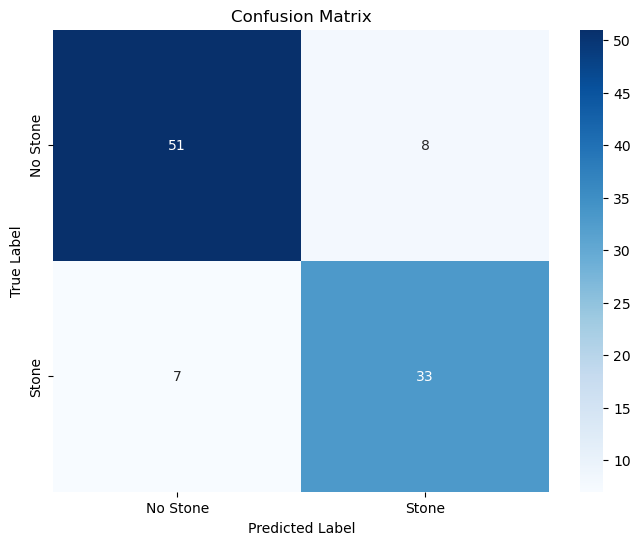


Feature Importances:
              Input Name  Importance
0  Calcium Concentration    0.295628
1                     ph    0.151911
2     Urea Concentration    0.142979
3           Conductivity    0.142738
4             Osmolarity    0.135157
5                gravity    0.131587


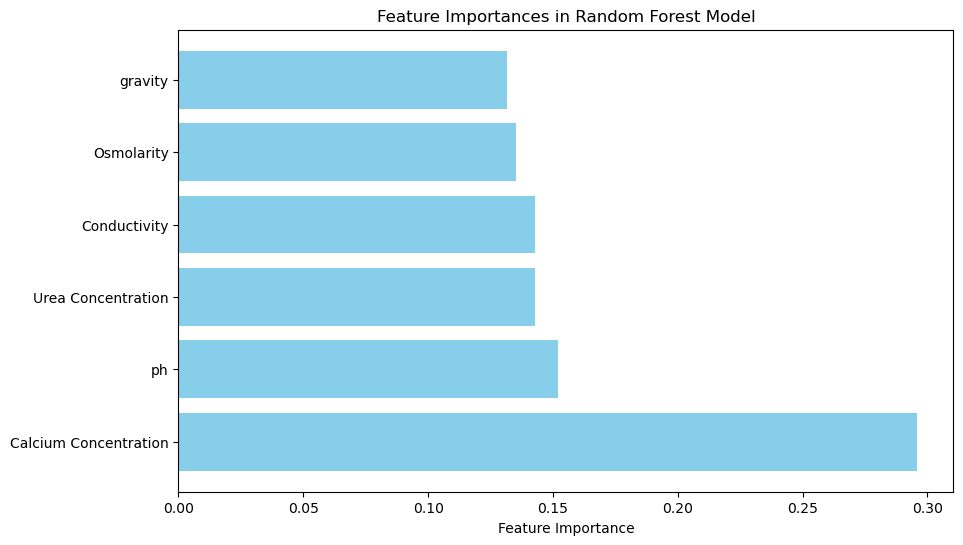

In [1]:
import os
import random
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.ensemble import RandomForestClassifier
import joblib  # For saving the model and scaler
import matplotlib.pyplot as plt
import seaborn as sns

# Set random seeds for reproducibility
def set_random_seed(seed_value=42):
    os.environ['PYTHONHASHSEED'] = str(seed_value)
    random.seed(seed_value)
    np.random.seed(seed_value)
    tf.random.set_seed(seed_value)

set_random_seed(42)

# Load dataset
data = pd.read_csv('urine.csv')

# Feature and target extraction
X = data[['gravity', 'ph', 'Osmolarity', 'Conductivity', 'Urea Concentration', 'Calcium Concentration']]
y = data['KidneyStone']  # Binary classification: 1 (stone present) or 0 (no stone)

# Normalize the feature data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data into training and testing sets (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=50)

# Instantiate and train the Random Forest model with class weights to penalize false negatives
random_forest = RandomForestClassifier(random_state=42, class_weight={0: 1, 1: 2})  # Higher weight for positive class
random_forest.fit(X_train, y_train)

# Save the trained Random Forest model and scaler
joblib.dump(random_forest, 'random_forest_model.pkl')  # Save the trained Random Forest model
joblib.dump(scaler, 'scaler.pkl')  # Save the scaler used for data normalization

# Make predictions on training and test data
y_train_pred = random_forest.predict(X_train)
y_test_proba = random_forest.predict_proba(X_test)[:, 1]  # Predicted probabilities for the positive class

# Adjust threshold to increase recall
threshold = 0.4  # Lowering threshold to classify more cases as positive (increase recall)
y_test_pred = (y_test_proba >= threshold).astype(int)

# Calculate accuracy, precision, recall, and F1 score for test data (validation accuracy)
test_accuracy = accuracy_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred)
test_recall = recall_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred)

# Calculate accuracy for training data
train_accuracy = accuracy_score(y_train, y_train_pred)

# Print training and validation accuracies
print(f"Random Forest Training Accuracy: {train_accuracy * 100:.2f}%")
print(f"Random Forest Validation Accuracy: {test_accuracy * 100:.2f}%")  # Test accuracy serves as validation accuracy

# Confusion matrix for test data
cm = confusion_matrix(y_test, y_test_pred)

# Extract True Positives, False Positives, True Negatives, and False Negatives
TN, FP, FN, TP = cm.ravel()

# Print confusion matrix and TP, FP, TN, FN values
print("Confusion Matrix:")
print(cm)
print(f"True Positives: {TP}")
print(f"False Positives: {FP}")
print(f"True Negatives: {TN}")
print(f"False Negatives: {FN}")

# Create a DataFrame for metrics
metrics_df = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1 Score'],
    'Score': [test_accuracy, test_precision, test_recall, test_f1]
})

# Print the DataFrame
print("\nEvaluation Metrics:")
print(metrics_df)

# Plot the confusion matrix using Seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True,
            xticklabels=['No Stone', 'Stone'], yticklabels=['No Stone', 'Stone'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Feature importances
importances = random_forest.feature_importances_
features = X.columns

# Create DataFrame for feature importances
importance_df = pd.DataFrame({
    'Input Name': features,
    'Importance': importances
})

# Sort the DataFrame by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False).reset_index(drop=True)

# Print the DataFrame
print("\nFeature Importances:")
print(importance_df)

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Input Name'], importance_df['Importance'], color='skyblue')
plt.xlabel('Feature Importance')
plt.title('Feature Importances in Random Forest Model')
plt.show()


Train Accuracy: 0.9949
Test Accuracy: 0.8485
Confusion Matrix:
[[51  8]
 [ 7 33]]
True Positives (TP): 33
True Negatives (TN): 51
False Positives (FP): 8
False Negatives (FN): 7

Classification Report:
             precision  recall f1-score    support
Normal          0.8793  0.8644   0.8718  59.000000
Stone           0.8049  0.8250   0.8148  40.000000
accuracy        0.8485  0.8485   0.8485   0.848485
macro avg       0.8421  0.8447   0.8433  99.000000
weighted avg    0.8492  0.8485   0.8488  99.000000


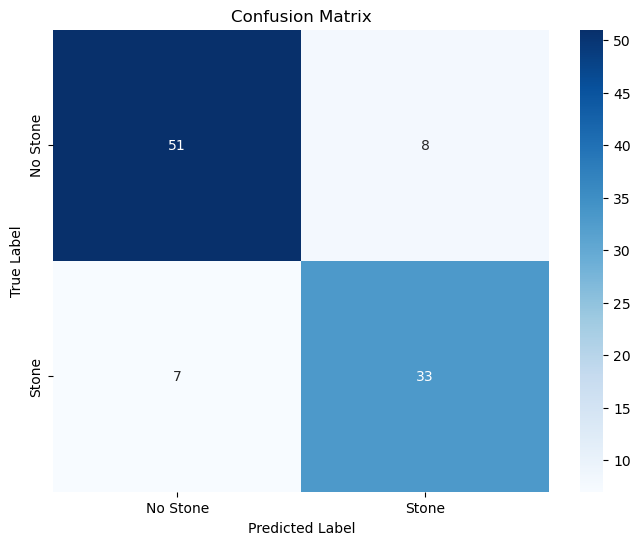


Feature Importances:
              Input Name  Importance
0  Calcium Concentration    0.295628
1                     ph    0.151911
2     Urea Concentration    0.142979
3           Conductivity    0.142738
4             Osmolarity    0.135157
5                gravity    0.131587


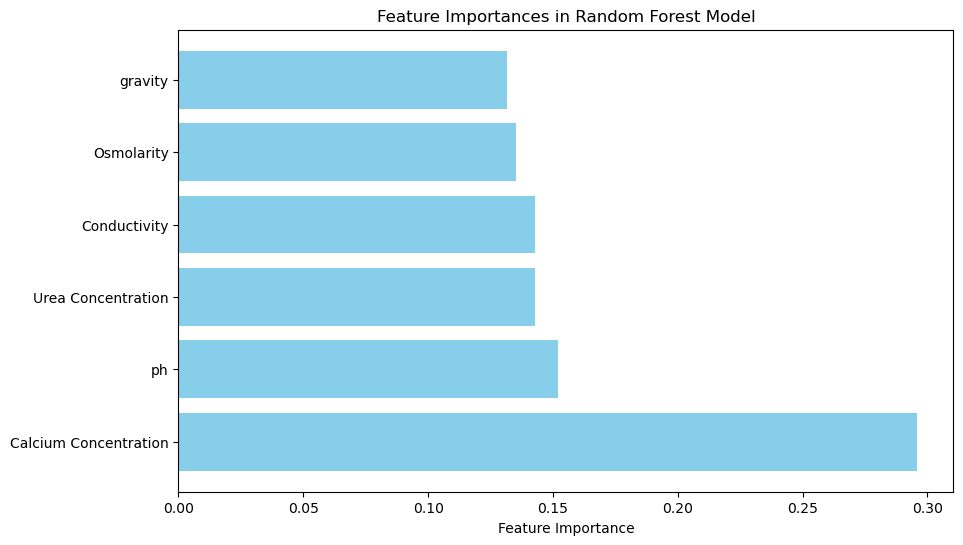

In [9]:
import os
import random
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, classification_report
from sklearn.ensemble import RandomForestClassifier
import joblib  # For saving the model and scaler
import matplotlib.pyplot as plt
import seaborn as sns

# Set random seeds for reproducibility
def set_random_seed(seed_value=42):
    os.environ['PYTHONHASHSEED'] = str(seed_value)
    random.seed(seed_value)
    np.random.seed(seed_value)
    tf.random.set_seed(seed_value)

set_random_seed(42)

# Load dataset
data = pd.read_csv('urine.csv')

# Feature and target extraction
X = data[['gravity', 'ph', 'Osmolarity', 'Conductivity', 'Urea Concentration', 'Calcium Concentration']]
y = data['KidneyStone']  # Binary classification: 1 (stone present) or 0 (no stone)

# Normalize the feature data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data into training and testing sets (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=50)

# Instantiate and train the Random Forest model with class weights to penalize false negatives
random_forest = RandomForestClassifier(random_state=42, class_weight={0: 1, 1: 2})  # Higher weight for positive class
random_forest.fit(X_train, y_train)

# Save the trained Random Forest model and scaler
joblib.dump(random_forest, 'random_forest_model.pkl')  # Save the trained Random Forest model
joblib.dump(scaler, 'scaler.pkl')  # Save the scaler used for data normalization

# Make predictions on training and test data
y_train_pred = random_forest.predict(X_train)
y_test_proba = random_forest.predict_proba(X_test)[:, 1]  # Predicted probabilities for the positive class

# Adjust threshold to increase recall
threshold = 0.4  # Lowering threshold to classify more cases as positive (increase recall)
y_test_pred = (y_test_proba >= threshold).astype(int)

# Calculate accuracy, precision, recall, and F1 score for test data (validation accuracy)
test_accuracy = accuracy_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred)
test_recall = recall_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred)

# Calculate accuracy for training data
train_accuracy = accuracy_score(y_train, y_train_pred)

# Print training and validation accuracies in the specified format
print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# Confusion matrix for test data
cm = confusion_matrix(y_test, y_test_pred)

# Extract True Positives, False Positives, True Negatives, and False Negatives
TN, FP, FN, TP = cm.ravel()

# Print confusion matrix and TP, FP, TN, FN values
print("Confusion Matrix:")
print(cm)
print(f"True Positives (TP): {TP}")
print(f"True Negatives (TN): {TN}")
print(f"False Positives (FP): {FP}")
print(f"False Negatives (FN): {FN}")

# Create a classification report and format it
class_report = classification_report(y_test, y_test_pred, target_names=['Normal', 'Stone'], output_dict=True)
report_df = pd.DataFrame(class_report).transpose()

# Format the classification report to 4 decimal places
report_df[['precision', 'recall', 'f1-score']] = report_df[['precision', 'recall', 'f1-score']].applymap(lambda x: f"{x:.4f}")

# Print the classification report in the specified format
print("\nClassification Report:")
print(report_df[['precision', 'recall', 'f1-score', 'support']])

# Plot the confusion matrix using Seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True,
            xticklabels=['No Stone', 'Stone'], yticklabels=['No Stone', 'Stone'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Feature importances
importances = random_forest.feature_importances_
features = X.columns

# Create DataFrame for feature importances
importance_df = pd.DataFrame({
    'Input Name': features,
    'Importance': importances
})

# Sort the DataFrame by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False).reset_index(drop=True)

# Print the DataFrame for feature importances
print("\nFeature Importances:")
print(importance_df)

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Input Name'], importance_df['Importance'], color='skyblue')
plt.xlabel('Feature Importance')
plt.title('Feature Importances in Random Forest Model')
plt.show()
